In [1]:
!pip install torch
!pip install torchsummary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary

"""
Implementation based on original paper NeurIPS 2016 https://papers.nips.cc/paper/6096-learning-a-probabilistic-latent-space-of-object-shapes-via-3d-generative-adversarial-modeling.pdf
"""


'\nImplementation based on original paper NeurIPS 2016 https://papers.nips.cc/paper/6096-learning-a-probabilistic-latent-space-of-object-shapes-via-3d-generative-adversarial-modeling.pdf\n'

## Discriminator

In [3]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=3, dim=64, out_conv_channels=512):
        super(Discriminator, self).__init__()
        conv1_channels = int(out_conv_channels / 8)
        conv2_channels = int(out_conv_channels / 4)
        conv3_channels = int(out_conv_channels / 2)
        self.out_conv_channels = out_conv_channels
        self.out_dim = int(dim / 16)

        self.conv1 = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels, out_channels=conv1_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv3d(
                in_channels=conv3_channels, out_channels=out_conv_channels, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(out_conv_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(out_conv_channels * self.out_dim * self.out_dim * self.out_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply linear + sigmoid
        x = x.view(-1, self.out_conv_channels * self.out_dim * self.out_dim * self.out_dim)
        x = self.out(x)
        return x


## Generator

In [4]:
class Generator(torch.nn.Module):
    def __init__(self, in_channels=512, out_dim=64, out_channels=1, noise_dim=200, activation="sigmoid"):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.out_dim = out_dim
        self.in_dim = int(out_dim / 16)
        conv1_out_channels = int(self.in_channels / 2.0)
        conv2_out_channels = int(conv1_out_channels / 2)
        conv3_out_channels = int(conv2_out_channels / 2)

        self.linear = torch.nn.Linear(noise_dim, in_channels * self.in_dim * self.in_dim * self.in_dim)

        self.conv1 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=in_channels, out_channels=conv1_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv1_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv2_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv2_out_channels, out_channels=conv3_out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm3d(conv3_out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose3d(
                in_channels=conv3_out_channels, out_channels=out_channels, kernel_size=(4, 4, 4),
                stride=2, padding=1, bias=False
            )
        )
        if activation == "sigmoid":
            self.out = torch.nn.Sigmoid()
        else:
            self.out = torch.nn.Tanh()

    def project(self, x):
        """
        projects and reshapes latent vector to starting volume
        :param x: latent vector
        :return: starting volume
        """
        return x.view(-1, self.in_channels, self.in_dim, self.in_dim, self.in_dim)

    def forward(self, x):
        x = self.linear(x)
        x = self.project(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.out(x)


## Test

In [10]:
def test_gan3d(print_summary=True):
    noise_dim = 200  # latent space vector dim
    in_channels = 512  # convolutional channels
    dim = 64  # cube volume
    model_generator = Generator(in_channels=512, out_dim=dim, out_channels=1, noise_dim=noise_dim)
    noise = torch.rand(1, noise_dim)
    generated_volume = model_generator(noise)
    print("Generator output shape", generated_volume.shape)
    model_discriminator = Discriminator(in_channels=1, dim=dim, out_conv_channels=in_channels)
    out = model_discriminator(generated_volume)
    print("Discriminator output", out.item())
    if print_summary:
        print("\n\nGenerator summary\n\n")
        summary(model_generator, (1, noise_dim))
        print("\n\nDiscriminator summary\n\n")
        summary(model_discriminator, (1, dim, dim, dim))

test_gan3d()

Generator output shape torch.Size([1, 1, 64, 64, 64])
Discriminator output 0.6263678073883057


Generator summary


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 32768]       6,586,368
   ConvTranspose3d-2         [-1, 256, 8, 8, 8]       8,388,608
       BatchNorm3d-3         [-1, 256, 8, 8, 8]             512
              ReLU-4         [-1, 256, 8, 8, 8]               0
   ConvTranspose3d-5      [-1, 128, 16, 16, 16]       2,097,152
       BatchNorm3d-6      [-1, 128, 16, 16, 16]             256
              ReLU-7      [-1, 128, 16, 16, 16]               0
   ConvTranspose3d-8       [-1, 64, 32, 32, 32]         524,288
       BatchNorm3d-9       [-1, 64, 32, 32, 32]             128
             ReLU-10       [-1, 64, 32, 32, 32]               0
  ConvTranspose3d-11        [-1, 1, 64, 64, 64]           4,096
          Sigmoid-12        [-1, 1, 64, 64, 64]    

Generator output shape torch.Size([1, 1, 64, 64, 64])
Discriminator output 0.5034919381141663


Generator summary


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 32768]       6,586,368
   ConvTranspose3d-2         [-1, 256, 8, 8, 8]       8,388,608
       BatchNorm3d-3         [-1, 256, 8, 8, 8]             512
              ReLU-4         [-1, 256, 8, 8, 8]               0
   ConvTranspose3d-5      [-1, 128, 16, 16, 16]       2,097,152
       BatchNorm3d-6      [-1, 128, 16, 16, 16]             256
              ReLU-7      [-1, 128, 16, 16, 16]               0
   ConvTranspose3d-8       [-1, 64, 32, 32, 32]         524,288
       BatchNorm3d-9       [-1, 64, 32, 32, 32]             128
             ReLU-10       [-1, 64, 32, 32, 32]               0
  ConvTranspose3d-11        [-1, 1, 64, 64, 64]           4,096
          Sigmoid-12        [-1, 1, 64, 64, 64]    

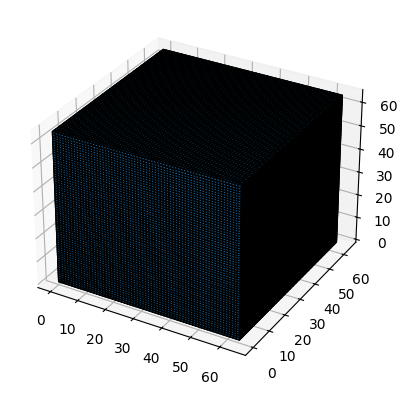

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def test_gan3d(print_summary=True):
    noise_dim = 200  # latent space vector dim
    in_channels = 512  # convolutional channels
    dim = 64  # cube volume
    model_generator = Generator(in_channels=512, out_dim=dim, out_channels=1, noise_dim=noise_dim)
    noise = torch.rand(1, noise_dim)
    generated_volume = model_generator(noise)
    print("Generator output shape", generated_volume.shape)
    model_discriminator = Discriminator(in_channels=1, dim=dim, out_conv_channels=in_channels)
    out = model_discriminator(generated_volume)
    print("Discriminator output", out.item())
    if print_summary:
        print("\n\nGenerator summary\n\n")
        summary(model_generator, (1, noise_dim))
        print("\n\nDiscriminator summary\n\n")
        summary(model_discriminator, (1, dim, dim, dim))

    # Convert the generated volume to a NumPy array and plot it
    generated_volume_np = generated_volume.detach().cpu().numpy()

    # Assuming the generated volume has shape (1, 1, 64, 64, 64)
    # we take the first element of the batch and the first channel
    volume_to_plot = generated_volume_np[0, 0, :, :, :]

    # Create a figure and axes for the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot using voxels
    ax.voxels(volume_to_plot, edgecolor='k')

    # Display the plot
    plt.show()

test_gan3d()

In [12]:
!pip install ipyvolume --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.2 MB/s eta 0:00:00


In [17]:
import ipyvolume as ipv
def test_gan3d(print_summary=True):
    noise_dim = 200  # latent space vector dim
    in_channels = 512  # convolutional channels
    dim = 64  # cube volume
    model_generator = Generator(in_channels=512, out_dim=dim, out_channels=1, noise_dim=noise_dim)
    noise = torch.rand(1, noise_dim)
    generated_volume = model_generator(noise)
    print("Generator output shape", generated_volume.shape)
    model_discriminator = Discriminator(in_channels=1, dim=dim, out_conv_channels=in_channels)
    out = model_discriminator(generated_volume)
    print("Discriminator output", out.item())
    if print_summary:
        print("\n\nGenerator summary\n\n")
        summary(model_generator, (1, noise_dim))
        print("\n\nDiscriminator summary\n\n")
        summary(model_discriminator, (1, dim, dim, dim))
    # Convert the generated volume to a NumPy array
    generated_volume_np = generated_volume.detach().cpu().numpy()
    # Assuming the generated volume has shape (1, 1, 64, 64, 64)
    volume_to_plot = generated_volume_np[0, 0, :, :, :]
    # Visualize with ipyvolume
    ipv.quickvolshow(volume_to_plot, level=[0.25, 0.75], opacity=0.5)  # Adjust level and opacity
    # OR
    fig = ipv.figure()
    vol = ipv.volshow(volume_to_plot, level=[0.2, 0.8], opacity=0.3)  # Adjust level and opacity
    ipv.show()

test_gan3d(False)

Generator output shape torch.Size([1, 1, 64, 64, 64])
Discriminator output 0.4589431583881378


Html(layout=None, style_='display: none', tag='span')

Html(layout=None, style_='display: none', tag='span')

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…